In [1]:
import numpy as np
from functools import reduce

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import array_to_latex, plot_state_qsphere, plot_bloch_multivector
from qiskit.extensions import Initialize

TOKEN = ''

from qiskit import transpile
from qiskit.providers.aer import QasmSimulator

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

C:\Users\MatiX\AppData\Local\Temp\ipykernel_17196\604304811.py:20: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [2]:
# IBMQ.save_account(TOKEN)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# Bernstein-Vazirani

In [3]:
N = 3
A = [1, 1, 0]

## Quantum solution

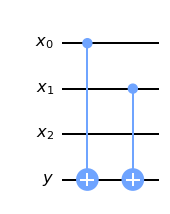

In [4]:
def bf_function_gate():
    x_register = QuantumRegister(N, name='x')
    y_register = QuantumRegister(1, name='y')
    circuit = QuantumCircuit(x_register, y_register, name='bf gate')
    for i in range(N):
        if A[i] == 1:
            circuit.cx(x_register[i], y_register[0])
    return circuit

bf_function_gate().draw('mpl')

In [5]:
def bf_solver_circuit(circuit, bf_gate, set_1=True):
    if set_1:
        circuit.x(N)
        circuit.barrier()
        
    for i in range(N + 1):
        circuit.h(i)
    circuit.barrier()
        
    circuit.append(bf_gate, [i for i in range(N + 1)])
    
    circuit.barrier()
    for i in range(N + 1):
        circuit.h(i)
        
    return circuit

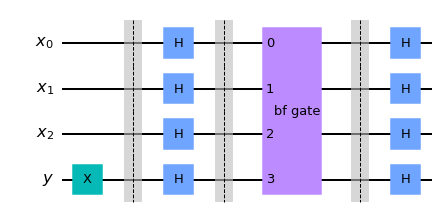

In [6]:
x_register = QuantumRegister(N, name='x')
y_register = QuantumRegister(1, name='y')

circuit = QuantumCircuit(x_register, y_register)
circuit = bf_solver_circuit(circuit, bf_function_gate())
circuit.draw('mpl')

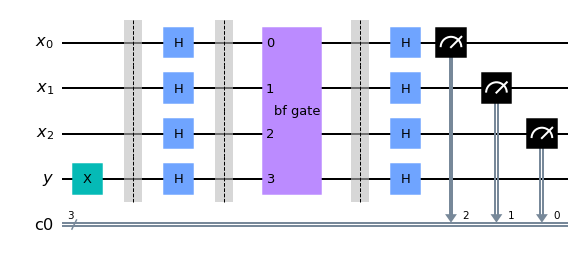

In [7]:
x_register = QuantumRegister(N, name='x')
y_register = QuantumRegister(1, name='y')
classical_register = ClassicalRegister(N)

circuit = QuantumCircuit(x_register, y_register, classical_register)
circuit = bf_solver_circuit(circuit, bf_function_gate())
circuit.measure(x_register, reversed(classical_register))
circuit.draw('mpl')

In [8]:
backend = QasmSimulator()

circuit_compiled = transpile(circuit, backend, optimization_level=0)
job_sim = backend.run(circuit_compiled, shots=1024)
result_sim = job_sim.result()
sim_counts = result_sim.get_counts(circuit_compiled)
print(sim_counts)

{'110': 1024}


In [9]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= N + 1 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

circuit_compiled = transpile(circuit, backend, optimization_level=0)

job_real = backend.run(circuit_compiled, shots=1024)
job_monitor(job_real, interval=1)
result_real = job_real.result()
real_counts = result_real.get_counts()
print(real_counts)

least busy backend:  ibmq_manila
Job Status: job has successfully run
{'000': 25, '001': 11, '010': 72, '011': 15, '100': 80, '101': 13, '110': 677, '111': 131}


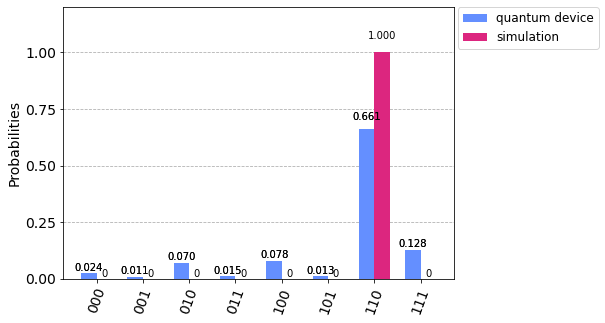

In [10]:
plot_histogram(data=[real_counts, sim_counts], legend=['quantum device', 'simulation'])

## Error mitigation

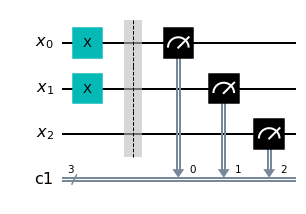

In [11]:
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], circlabel='mcal')

cal_circuits[3].draw('mpl')

Job Status: job has successfully run


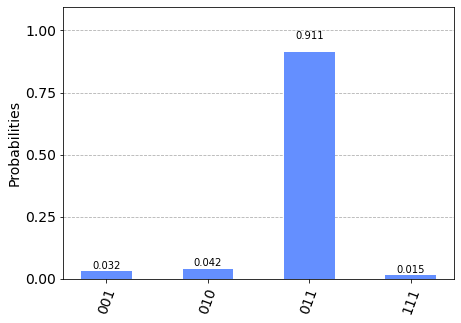

In [12]:
job_mit = backend.run(cal_circuits, shots=1024)
job_monitor(job_mit, interval=1)
result_mit = job_mit.result()
mit_counts = result_mit.get_counts()

plot_histogram(mit_counts[3])

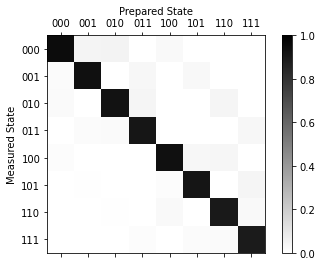

In [13]:
meas_fitter = CompleteMeasFitter(result_mit, state_labels)
meas_fitter.plot_calibration()

In [14]:
meas_filter = meas_fitter.filter

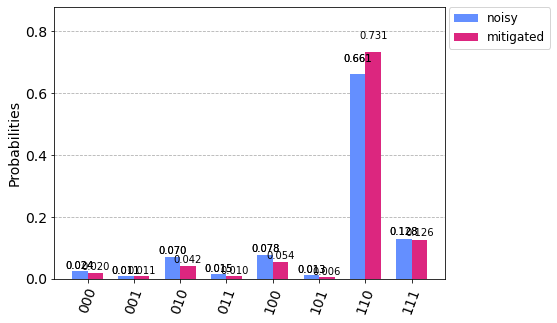

In [15]:
result_real_mit = meas_filter.apply(result_real)
real_mit_counts = result_real_mit.get_counts()

plot_histogram(data=[real_counts, real_mit_counts], legend=['noisy', 'mitigated'])